### Open your terminal and run the following lines one by one
git clone https://github.com/ultralytics/yolov5

cd yolov5

pip install -r requirements.txt

In [5]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd

In [1]:
input_path = 'kaggle/input/road-sign-detection'
output_path = 'yolov5'

In [9]:
annotations_path = os.path.join(input_path, 'annotations')
annotations = os.listdir(annotations_path)

In [10]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text
        
        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)


100%|██████████| 877/877 [00:00<00:00, 18916.00it/s]


In [11]:
labels_df = pd.DataFrame({
                        'img_name': img_name_list, 
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label
0,road407.png,300,400,167,219,179,230,speedlimit
1,road578.png,300,400,223,134,270,180,crosswalk
2,road578.png,300,400,223,92,265,133,speedlimit
3,road358.png,300,400,92,194,124,226,speedlimit
4,road358.png,300,400,27,294,37,313,crosswalk


In [12]:
%pip install pybboxes

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import pandas as pd
import os
import pybboxes as pbx
from collections import defaultdict
from tqdm import tqdm
import shutil

In [14]:
classes = labels_df['label'].unique().tolist()
classes

['speedlimit', 'crosswalk', 'trafficlight', 'stop']

In [15]:
## Add class number associated to classes
labels_df['class'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label,class
0,road407.png,300,400,167,219,179,230,speedlimit,0
1,road578.png,300,400,223,134,270,180,crosswalk,1
2,road578.png,300,400,223,92,265,133,speedlimit,0
3,road358.png,300,400,92,194,124,226,speedlimit,0
4,road358.png,300,400,27,294,37,313,crosswalk,1


In [16]:
## Generate dictionary where key is image_name and value is list of all bboxes inforamtion
img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))
    
    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)


100%|██████████| 1244/1244 [00:00<00:00, 4979.18it/s]


In [19]:
ls

archive.zip  input/  kaggle/  roadsigndetection.ipynb  yolov5/


In [21]:
# make labels dir in data folder of yolov5
labels_dir = f'{output_path}/data/labels'
if os.path.exists(labels_dir):
    shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

In [22]:
## Generate .txt file for each image
for img_name, lines in img_dict.items():
    img_name = img_name.split('.')[0]
    with open(f'{labels_dir}/{img_name}.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [3]:
import os
import shutil
from random import shuffle

In [24]:
images_path = input_path + '/images'
labels_path = labels_dir   ## directory having labels in .txt format

In [25]:
# create train , val folders in data directory of yolov5
train_dir = output_path + '/data/train'
val_dir = output_path + '/data/val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
    
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
    
os.mkdir(train_dir)
os.mkdir(val_dir)

# train, val each containing images and labels folders
os.mkdir(train_dir + '/images')
os.mkdir(train_dir + '/labels')
os.mkdir(val_dir + '/images')
os.mkdir(val_dir + '/labels')


In [26]:
# Shuffle image file names before splitting into train and val data
files = os.listdir(images_path)
shuffle(files)

In [27]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]

def copy_files(images_path, labels_path, destination_path, files):
    
    for file_name in files:
        file_name = file_name.split('.')[0]

        src = images_path + f'/{file_name}.png'
        dst = destination_path + '/images'
        shutil.copy(src, dst)

        src = labels_path + f'/{file_name}.txt'
        dst = destination_path + '/labels'
        shutil.copy(src, dst)

In [28]:
images_path, labels_path, train_dir

('kaggle/input/road-sign-detection/images',
 'yolov5/data/labels',
 'yolov5/data/train')

In [29]:
# Split and copy files in train and val folder
train_ratio = 0.75
train_files, val_files = split(files, train_ratio)

root = 'data/traffic_sign_data'

copy_files(images_path, labels_path, train_dir, train_files)
copy_files(images_path, labels_path, val_dir, val_files)

In [30]:
assert (len(os.listdir(train_dir + '/images')) + len(os.listdir(val_dir + '/images')) == len(os.listdir(images_path)))

**Generate .yaml file**

In [31]:
with open(f'{output_path}/data/sign_data.yaml', 'w') as f:
    f.write('train: ../data/train/images\n')
    f.write('val: ../data/val/images\n')
    f.write('nc: 4\n')
    f.write(f"names: {classes}")

In [38]:
# epochs = 20
# %python train.py --img 640 --batch 16 --epochs {epochs} --data sign_data.yaml --weights yolov5s.pt

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [ ]:
# Open your command prompt (or terminal) and run the following line
cd yolov5
python3 train.py --img 640 --batch 16 --epochs 2 --data sign_data.yaml --weights yolov5s.pt

In [4]:
# results stored in runs/train 
# get the last stored result
exp = sorted(os.listdir(output_path + '/runs/train'))[-1]
exp_path = output_path + '/runs/train/' + exp

In [5]:
os.listdir(exp_path)

['results.png',
 'weights',
 'train_batch2.jpg',
 'val_batch0_labels.jpg',
 'val_batch2_labels.jpg',
 'labels.jpg',
 'val_batch1_labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch2_pred.jpg',
 'PR_curve.png',
 'train_batch0.jpg',
 'events.out.tfevents.1694171269.asus.59327.0',
 'train_batch1.jpg',
 'opt.yaml',
 'confusion_matrix.png',
 'F1_curve.png',
 'labels_correlogram.jpg',
 'R_curve.png',
 'P_curve.png',
 'hyp.yaml',
 'results.csv',
 'val_batch1_pred.jpg']

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

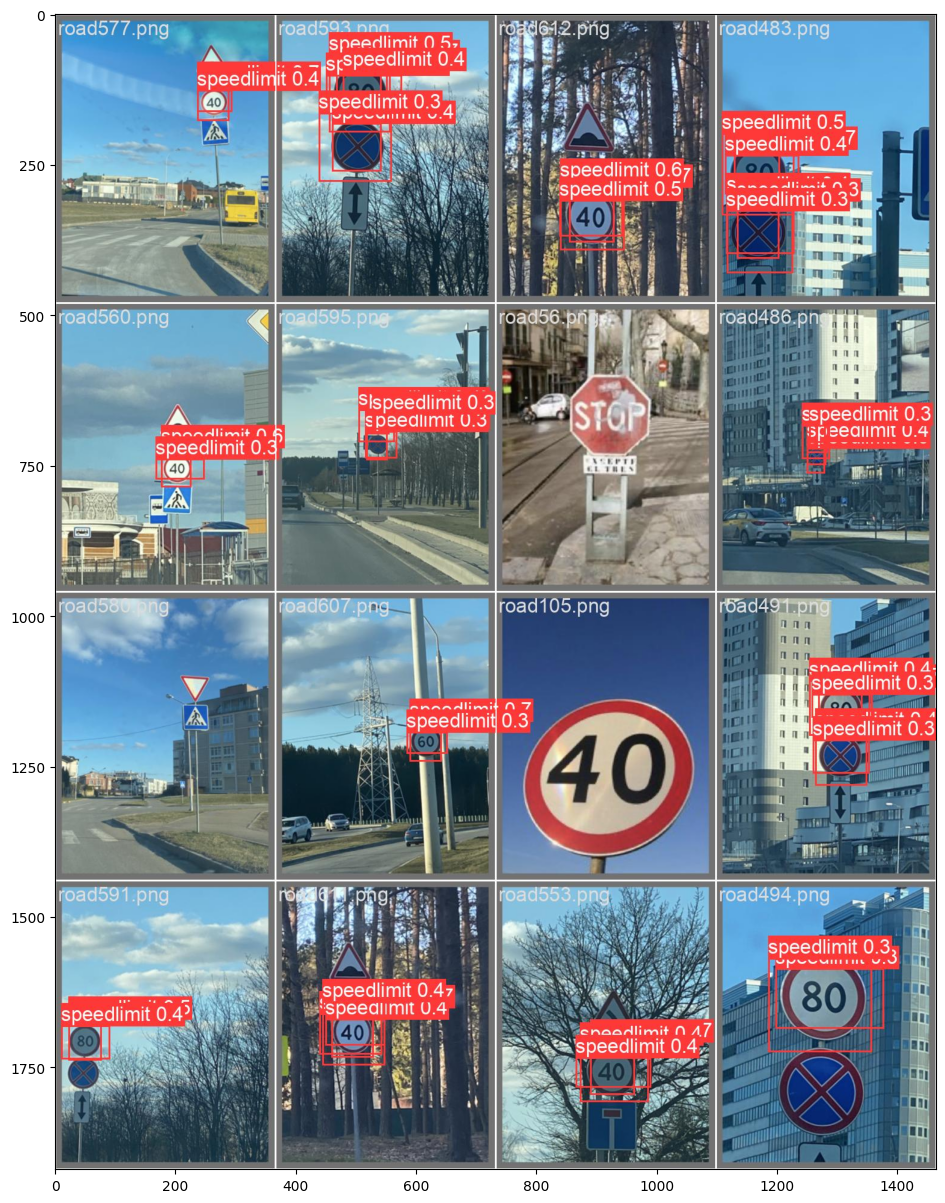

In [8]:
img_path = exp_path + '/val_batch1_pred.jpg'
img = Image.open(img_path)
plt.figure(figsize=(15, 15))
plt.imshow(img)